### Import needed libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib
from scipy import stats, integrate
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline
import seaborn.apionly as sns

import warnings
warnings.filterwarnings('ignore')

### Load the dataset
Specifically the set with genre's imputed from the artists and full audio description.

In [46]:
df = pd.read_csv('playlists_categories_plus_audio_artists_metagenres.csv', encoding='ISO-8859-1')

Edit the dataset to contain only the relevant predictors, one hot encod the genres and recover the mode data

In [47]:
# Drop the playlist ID column; only kept as a backup to grab other data from Spotify if needed later
df = df.drop(['playlist_id', "playlist_name"], axis=1)
df = df.drop(df[df.genre == "None"].index)

In [48]:
df = pd.get_dummies(df, columns=["genre"], drop_first=True)

In [49]:
df.loc[df['average_mode'] >= 0.5, 'average_mode'] = 1
df.loc[df['average_mode'] < 0.5, 'average_mode'] = 0 
df.head()

,followers,average_danceability,average_energy,average_key,average_loudness,average_mode,average_speechiness,average_acousticness,average_instrumentalness,average_liveness,...,genre_pop,genre_punk,genre_rap,genre_reggae,genre_religious,genre_rock,genre_soul,genre_soundtrack,genre_speech,genre_world
0,18098330,0.671280,0.655880,4.980000,-5.443000,1.0,0.082964,0.197658,0.000011,0.155500,...,1,0,0,0,0,0,0,0,0,0
1,8295257,0.752765,0.622176,5.568627,-6.668294,1.0,0.234988,0.178904,0.000019,0.194763,...,0,0,1,0,0,0,0,0,0,0
2,4595392,0.649760,0.775480,4.460000,-5.624800,1.0,0.072348,0.116406,0.133080,0.188764,...,0,0,0,0,0,0,0,0,0,0
3,3777270,0.627640,0.538420,5.280000,-7.312480,1.0,0.129162,0.223716,0.016297,0.137370,...,1,0,0,0,0,0,0,0,0,0
4,3992066,0.526160,0.787100,5.000000,-5.252220,1.0,0.064722,0.050970,0.024833,0.202988,...,0,0,0,0,0,1,0,0,0,0


## Treat Data

In [50]:
#split dataset
np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]


Find the average follower count to help inform the threshold between a popular and unpopular playlist (determined using the number of followers)

In [51]:
average_follower_count = sum(df["followers"])/df["followers"].shape[0]
print("The average number of followers is", average_follower_count)

The average number of followers is 217349.213793


Using that threshhold and some padding, change the followers response variable from quantitative to categorical

In [52]:
#create a categorical followers variable for train (0 being "unpopular", 1 being "popular")
follower_categorical_train = []
for ind, element in enumerate (data_train["followers"]):
    if element >= 250000:
        follower_categorical_train.append(1)
    else:
        follower_categorical_train.append(0)
data_train['followers_categorical'] = pd.Series(follower_categorical_train, index=data_train.index)

In [53]:
#create a categorical followers variable for test (0 being "unpopular", 1 being "popular")
follower_categorical_test = []
for ind, element in enumerate (data_test["followers"]):
    if element >= 250000:
        follower_categorical_test.append(1)
    else:
        follower_categorical_test.append(0)
data_test['followers_categorical'] = pd.Series(follower_categorical_test, index=data_test.index)

In [54]:
#normalization, taken from pset 5
NORMALIZATION_STRATEGY = 0 # choose 0 for [0,1] scaling, choose 1 for (x-mu)/sd

def normalize_columns_strat0(X, X_min, X_max):
    return (X-X_min)/(X_max-X_min)

def normalize_columns_strat1(X, X_mu, X_sd):
    return (X-X_mu)/X_sd

if NORMALIZATION_STRATEGY==1:
    X_mu = np.append(0,np.mean(data_train,axis=0)[1:])
    X_sd = np.append(1,np.std(data_train,axis=0)[1:])
    data_train = normalize_columns_strat1(X=data_train, X_mu=X_mu, X_sd=X_sd)
    data_test = normalize_columns_strat1(X=data_test, X_mu=X_mu, X_sd=X_sd)
    assert np.allclose(np.mean(data_train,axis=0)[1:],0)
else:
    X_min = np.min(data_train.drop("followers", axis=1),axis=0)
    X_max = np.max(data_train.drop("followers", axis=1),axis=0)
    data_train_without_f = normalize_columns_strat0(X=data_train.drop("followers", axis=1), X_min=X_min, X_max=X_max)
    data_test_without_f = normalize_columns_strat0(X=data_test.drop("followers", axis=1), X_min=X_min, X_max=X_max)   
#     assert np.max(data_train.values)==1 and np.min(data_train.values)==0

After normalizing and manipulating our response variable, put them back into the train and test sets

In [55]:
data_train_without_f["followers"] = data_train["followers"]
data_test_without_f["followers"] = data_test["followers"]
data_train = data_train_without_f.copy()
data_test = data_test_without_f.copy()

## Base Models


We begin with a few basic models to start our initial findings

#### KNN 

In [56]:
X_train = data_train["max_popularity"]
y_train = data_train["followers_categorical"]
X_test = data_test["max_popularity"]
y_test = data_test["followers_categorical"]

max_score = 0
max_k = 0 

for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn,X_train.reshape(X_train.shape[0],1),y_train).mean()
    if score > max_score:
        max_k = k
        max_score = score

print("The optimal k is: ", max_k)
print("The accuracy score using that k is: ", max_score)

The optimal k is:  22
The accuracy score using that k is:  0.822166232748


#### Simple Linear Regression (Quantitative)

Test Mean squared error: 337266472892.05
Test R^2 Score:  0.0624109561652


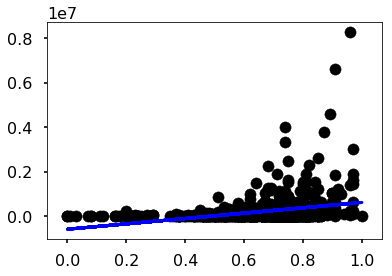

In [57]:
X_train = data_train["max_popularity"]
y_train = data_train["followers"]
X_test = data_test["max_popularity"]
y_test = data_test["followers"]

linreg = LinearRegression()
linreg.fit(X_train.reshape(X_train.shape[0],1), y_train.reshape(y_train.shape[0],1))
y_pred = linreg.predict(X_test.reshape(X_test.shape[0],1))

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
print("Test Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print("Test R^2 Score: ", r2_score(y_test, y_pred))
linear_quant_r2 = r2_score(y_test, y_pred)

#### Simple Linear Regression (Categorical)

In [58]:
X_train = data_train["max_popularity"]
y_train = data_train["followers_categorical"]
X_test = data_test["max_popularity"]
y_test = data_test["followers_categorical"]

X_train_wcons = sm.add_constant(X_train)
X_test_wcons = sm.add_constant(X_test)

# fit
ols = OLS(endog=y_train, exog=X_train_wcons).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     followers_categorical   R-squared:                       0.094
Model:                               OLS   Adj. R-squared:                  0.092
Method:                    Least Squares   F-statistic:                     75.40
Date:                   Thu, 07 Dec 2017   Prob (F-statistic):           2.51e-17
Time:                           12:22:43   Log-Likelihood:                -317.48
No. Observations:                    731   AIC:                             639.0
Df Residuals:                        729   BIC:                             648.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3320      0.062     -5.380      0.000      -0.453      -0.211
max_popularity     0.7734      0.089      8.683      0.000       0.599       0.948
==============================================================================
Omnibus:                      136.092   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.987
Skew:                           1.336   Prob(JB):                     2.80e-48
Kurtosis:                       3.213   Cond. No.                         9.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test Mean squared error: 0.14
Test R^2 Score:  0.0805912337994
ols single predictor accuracy in train = 0.810
ols single predictor accuracy in test = 0.814


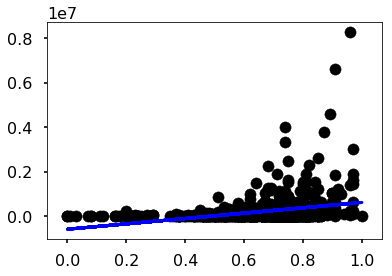

In [59]:
# predictions
y_hat_ols_train = ols.predict(X_train_wcons)
y_hat_ols_test = ols.predict(X_test_wcons)
# accuracy
print("Test Mean squared error: %.2f"% mean_squared_error(y_test, y_hat_ols_test))
print("Test R^2 Score: ", r2_score(y_test, y_hat_ols_test))
print("ols single predictor accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_ols_train>0.5))
print("ols single predictor accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_ols_test>0.5))

plt.scatter(X_test, data_test["followers"],  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
linear_r2 = r2_score(y_test, y_hat_ols_test)

#### Logistic Regression

In [60]:
X_train = data_train["max_popularity"]
y_train = data_train["followers_categorical"]
X_test = data_test["max_popularity"]
y_test = data_test["followers_categorical"]

X_train_wcons = sm.add_constant(X_train)
X_test_wcons = sm.add_constant(X_test)

logreg = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), fit_intercept=False)
logreg.fit(X_train_wcons, y_train)


LogisticRegressionCV(Cs=[1e-10, 1.0000000000000001e-09, 1e-08, 9.9999999999999995e-08, 9.9999999999999995e-07, 1.0000000000000001e-05, 0.0001, 0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0],
           class_weight=None, cv=None, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [61]:
y_hat_logreg_train = logreg.predict_proba(X_train_wcons)[:,1]
y_hat_logreg_test = logreg.predict_proba(X_test_wcons)[:,1]

# accuracy
print("logit single predictor accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_logreg_train>0.5))
print("logit single predictor accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_logreg_test>0.5))
log_reg_score = accuracy_score(y_test, y_hat_logreg_test>0.5)

logit single predictor accuracy in train = 0.825
logit single predictor accuracy in test = 0.814


These models all appear to perform roughly the same, with the KNN Regression performing the best. Now we will expand upon these initial models to improve the accuracy of the predictions we are making

#### Multi-Linear Regression

Using predictors that we found significant during EDA:

In [62]:
#Regression with only a few predictors
predictors = ["average_duration_ms", "total_duration", "total_num", "max_popularity"]

X_train = sm.add_constant(data_train[predictors])
y_train = data_train["followers_categorical"]
X_test = sm.add_constant(data_test[predictors])
y_test = data_test["followers_categorical"]

model = OLS(endog=y_train, exog=X_train)
result = model.fit()

y_hat_train_multi = result.predict()
y_hat_test_multi = result.predict(exog=X_test)

#MSE, R^2
print("Test Mean squared error: %.2f"% mean_squared_error(y_test, y_hat_test_multi))
print('Test R^2 Score: ', r2_score(data_test['followers_categorical'], y_hat_test_multi))

#Accuracy
print("ols single predictor accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_train_multi>0.5))
print("ols single predictor accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_test_multi>0.5))

Test Mean squared error: 0.14
Test R^2 Score:  0.105367400332
ols single predictor accuracy in train = 0.813
ols single predictor accuracy in test = 0.814


Seeing that these did not enhance the model greatly, we reran it using all the predictors

In [63]:
#all predictors
predictors = ["average_danceability","average_energy","average_key","average_loudness",
              "average_mode","average_speechiness","average_acousticness",
              "average_instrumentalness","average_liveness","average_valence",
              "average_tempo","average_time_signature",
              "average_duration_ms", "total_duration", "total_num", "max_popularity"]

X_train = sm.add_constant(data_train[predictors])
y_train = data_train["followers_categorical"]
X_test = sm.add_constant(data_test[predictors])
y_test = data_test["followers_categorical"]

model = OLS(endog=y_train, exog=X_train)
result = model.fit()

y_hat_train_multi_all = result.predict()
y_hat_test_multi_all = result.predict(exog=X_test)

#MSE, R^2
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_hat_test_multi_all))
print('Test R^2 Score: ', r2_score(data_test['followers_categorical'], y_hat_test_multi_all))

#Accuracy
print("ols single predictor accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_train_multi_all>0.5))
print("ols single predictor accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_test_multi_all>0.5))
mult_lin_score = accuracy_score(y_test, y_hat_test_multi_all>0.5)

Mean squared error: 0.13
Test R^2 Score:  0.134516040683
ols single predictor accuracy in train = 0.829
ols single predictor accuracy in test = 0.815


#### Multiple Logistic Regression

In [64]:
X_train = data_train.drop(["followers", "followers_categorical"], axis=1)
y_train = data_train["followers_categorical"]
X_test = data_test.drop(["followers", "followers_categorical"], axis=1)
y_test = data_test["followers_categorical"]

logregmul = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), fit_intercept=False)
X_train_mul_log = sm.add_constant(X_train)
X_test_mul_log = sm.add_constant(X_test)
logregmul.fit(X_train_mul_log, y_train)

LogisticRegressionCV(Cs=[1e-10, 1.0000000000000001e-09, 1e-08, 9.9999999999999995e-08, 9.9999999999999995e-07, 1.0000000000000001e-05, 0.0001, 0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0],
           class_weight=None, cv=None, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [65]:
y_hat_logregmul_train = logregmul.predict(X_train_mul_log)
y_hat_logregmul_test = logregmul.predict(X_test_mul_log)

# accuracy
print("logit all predictors accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_logregmul_train))
print("logit all predictors accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_logregmul_test))
mult_log_score = accuracy_score(y_test, y_hat_logregmul_test)

logit all predictors accuracy in train = 0.882
logit all predictors accuracy in test = 0.857


We thought it would be import to look at the confusion matrix for Multi Logistic Regression as another metric by which to evalute the model

In [66]:
cmatrix = confusion_matrix(y_test,logregmul.predict(X_test_mul_log))
print("TP Rate: ",  cmatrix[1][1]/(sum(cmatrix[1])))
print(cmatrix)

TP Rate:  0.477611940299
[[552  33]
 [ 70  64]]


In [67]:
print("False Positive rate:", cmatrix[0][1]/sum(cmatrix[0]))
print("False Negative rate:", cmatrix[1][0]/sum(cmatrix[1]))

False Positive rate: 0.0564102564103
False Negative rate: 0.522388059701


#### Multi Logistic Regression w/ Polynomial Features

During EDA, we saw some quadratic shapes in our data so we then added quadratic terms to our Multi Logistic Regression Model

In [68]:
cont_variables = ['average_danceability', 'average_energy', 'average_key',
       'average_loudness', 'average_mode', 'average_speechiness',
       'average_acousticness', 'average_instrumentalness', 'average_liveness',
       'average_valence', 'average_tempo', 'average_time_signature',
       'average_duration_ms', 'total_duration', 'total_num', 'max_popularity',
       'avg_popularity']
cat_variables = ['genre_blues', 'genre_children', 'genre_christmas',
       'genre_classical', 'genre_comedy', 'genre_country', 'genre_dance',
       'genre_electronic', 'genre_indie', 'genre_metal', 'genre_oldies',
       'genre_other', 'genre_pop', 'genre_punk', 'genre_rap', 'genre_reggae',
       'genre_religious', 'genre_rock', 'genre_soul', 'genre_soundtrack',
       'genre_speech', 'genre_world']

In [69]:
X_train = data_train.drop(["followers", "followers_categorical"], axis=1)
y_train = data_train["followers_categorical"]
X_test = data_test.drop(["followers", "followers_categorical"], axis=1)
y_test = data_test["followers_categorical"]

for cont in cont_variables:
    name = cont + "_squared"
    X_train[name] = X_train[cont] ** 2
    X_test[name] = X_test[cont] ** 2

#lrm_ovr2 = LogisticRegressionCV()
lrm = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), cv=5, penalty='l2')
lrm.fit(X_train, y_train)

print('Polynomial Logistic Regression Test Score: ', accuracy_score(y_test, lrm.predict(X_test)))
mult_log_poly_score = accuracy_score(y_test, lrm.predict(X_test))


Polynomial Logistic Regression Test Score:  0.858136300417


#### With Interaction Terms

In order to determine the effects that using a combination of predictors has on a model, we added interaction terms

In [70]:
# for each categorical variable
for cont in cont_variables:
    for cat in cat_variables:
        name = cont + "_" + cat
        X_train[name] = X_train[cont] * X_train[cat]
        X_test[name] = X_test[cont] * X_test[cat]

log_interact = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), fit_intercept=False)
log_interact.fit(X_train, y_train)
y_hat_train = log_interact.predict(X_train)
y_hat_test = log_interact.predict(X_test)

print("The accuracy score with all polynomials and interaction terms is", accuracy_score(y_test, y_hat_test))
mult_log_poly_inter_score = accuracy_score(y_test, y_hat_test)

The accuracy score with all polynomials and interaction terms is 0.835883171071


#### Significance of Coefficients

After some general insight given to us by the success of the models, we thought it would be helpful to determine which of the predictors actually had a significant effect on the models to better tune them

In [71]:
# 100 times: create a bootstrapped sample and find the confidence interval

X_train = data_train.drop(["followers", "followers_categorical"], axis=1)
y_train = data_train["followers_categorical"]
X_test = data_test.drop(["followers", "followers_categorical"], axis=1)
y_test = data_test["followers_categorical"]

predictor_dict = {}
all_predictors = X_train.columns
data_train = X_train.copy()
data_train["followers_categorical"] = y_train

for i in range(100):
    # Resample to get the new sample
    bootstrap_sample = resample(data_train)
    # Fit the model on this new boostrapped sample
    multi_log_model = LogisticRegression(C=100000)
    multi_log_model.fit(bootstrap_sample.drop('followers_categorical', axis=1), bootstrap_sample['followers_categorical'])
    for idx,val in enumerate(all_predictors):
        # If the predictor_dict does not yet have this predictor in it:
        if val in predictor_dict:
            predictor_dict[val].append(multi_log_model.coef_[0][idx])
        else:
            predictor_dict[val] = [multi_log_model.coef_[0][idx]]

In [73]:
# Order each list in predictor_dict
for k,v in predictor_dict.items():
    predictor_dict[k].sort()
# Find the middle 95% percentile of each list and check if 0 is in there
count = 0
significant_predictors = []
for k,v in predictor_dict.items():
    lower = np.percentile(v, 2.5)
    upper = np.percentile(v, 97.5)
    if (lower <= 0) and (upper >= 0):
        count = count + 1
    else:
        significant_predictors.append(k)
print("The number of significant predictors is", len(predictor_dict) - count, "out of all", len(predictor_dict), "predictors")
print("The significant predictors are", significant_predictors)

The number of significant predictors is 10 out of all 39 predictors
The significant predictors are ['average_duration_ms', 'total_duration', 'max_popularity', 'avg_popularity', 'genre_christmas', 'genre_comedy', 'genre_oldies', 'genre_punk', 'genre_soul', 'genre_speech']


### Reduce Dimensionality using Principal Component Analysis

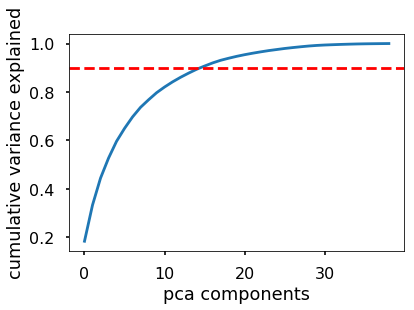

In [74]:
pca = PCA()
pca.fit(X_train)
var_c = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(len(var_c)), var_c)
plt.axhline(0.9,ls='--',color='red')
plt.xlabel("pca components")
plt.ylabel("cumulative variance explained");

This visualization shows us that 90% of our variance can be explained using at least roughly 15 components.

Approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors, as advised in HW5.

In [75]:
n_components_pca = np.sum(var_c<0.9)
print("The first %i components explain %0.3f of variance" % (n_components_pca, var_c[n_components_pca]))

X_train_pca = pca.transform(X_train)[:,:n_components_pca]
X_test_pca = pca.transform(X_test)[:,:n_components_pca]

The first 15 components explain 0.907 of variance


In [76]:
logregpca = LogisticRegression(C=100000, fit_intercept=True)
logregpca.fit(X_train_pca, y_train)
y_hat_pca_train = logregpca.predict(X_train_pca)
y_hat_pca_test = logregpca.predict(X_test_pca)
print("The logistic regression model with pca 90pct + logit accuracy in train = %0.3f" % accuracy_score(y_train, y_hat_pca_train))
print("The logistic regression model with pca 90pct + logit accuracy in test = %0.3f" % accuracy_score(y_test, y_hat_pca_test))
pca_score = accuracy_score(y_test, y_hat_pca_test)

The logistic regression model with pca 90pct + logit accuracy in train = 0.840
The logistic regression model with pca 90pct + logit accuracy in test = 0.836


In [77]:
X_train_pca

array([[ -8.48444580e-01,  -3.54894451e-01,  -2.39523806e-01, ...,
         -6.12449434e-02,  -1.03426612e-01,  -5.25262799e-02],
       [ -2.14180916e-01,   2.23945910e-01,  -8.17654259e-02, ...,
         -2.26663894e-01,  -5.87380380e-02,   5.81404666e-02],
       [  3.63895602e-01,  -1.04554399e-01,  -6.64258813e-02, ...,
         -2.75000607e-02,  -6.82206944e-02,  -5.44221322e-02],
       ..., 
       [ -4.93297879e-01,  -4.90087174e-01,  -3.46178142e-01, ...,
         -1.64676913e-02,  -3.29347305e-03,   1.07597833e-03],
       [ -7.75901311e-01,  -3.64626955e-01,  -2.50882323e-01, ...,
         -3.76443888e-02,  -2.59564613e-02,  -2.54538113e-02],
       [ -5.05367129e-01,  -5.61525143e-01,  -4.11828957e-01, ...,
          2.60916739e-05,  -1.85585368e-01,  -1.14554695e-01]])

## Visualize the Results

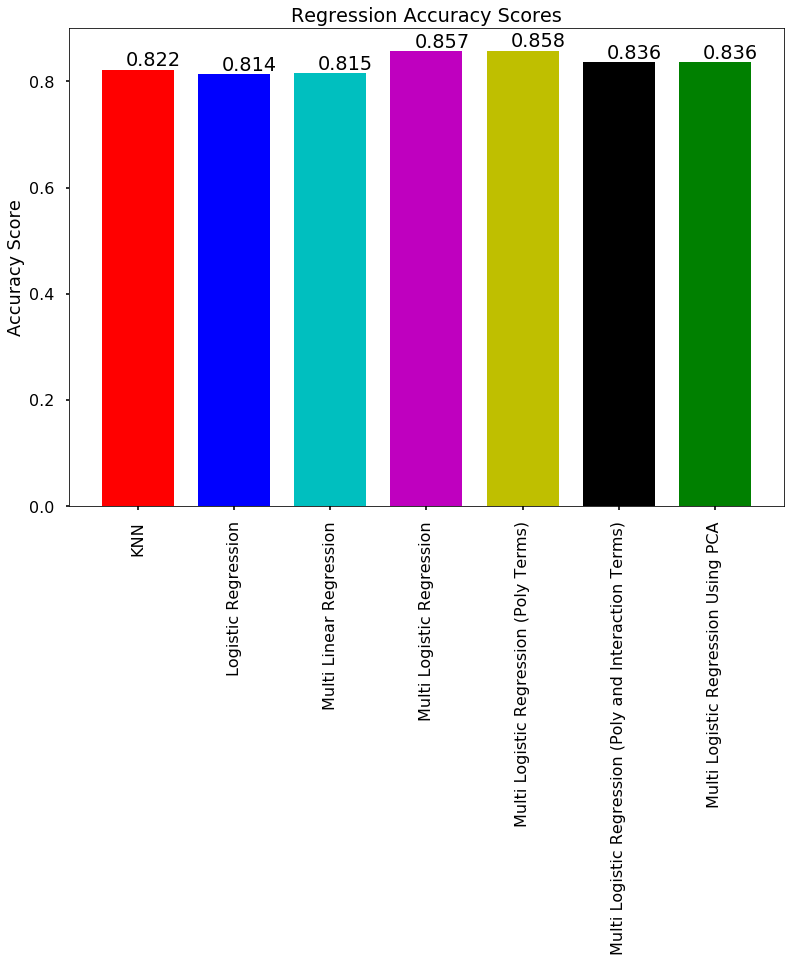

In [78]:
#referenced: https://matplotlib.org/examples/api/barchart_demo.html
sns.set_context("poster")
fig, ax = plt.subplots()

width = 0.75       # the width of the bars

rects1 = ax.bar(1, max_score, width, color='r', label='KNN')
rects2 = ax.bar(2, log_reg_score, width, color='b', label='Logistic Regression')
rects3 = ax.bar(3, mult_lin_score, width, color='c', label='Multi Linear Regression')
rects4 = ax.bar(4, mult_log_score, width, color='m', label='Multi Logistic Regression')
rects5 = ax.bar(5, mult_log_poly_score, width, color='y', label='Multi Logistic Regression (Poly Terms)')
rects6 = ax.bar(6, mult_log_poly_inter_score, width, color='k', label='Multi Logistic Regression (Poly and Interaction Terms)')
rects7 = ax.bar(7, pca_score, width, color='g', label='Multi Logistic Regression Using PCA')

labels = ['pad','KNN', 'Logistic Regression','Multi Linear Regression', 'Multi Logistic Regression', 'Multi Logistic Regression (Poly Terms)',
          'Multi Logistic Regression (Poly and Interaction Terms)', 'Multi Logistic Regression Using PCA']

ax.set_xticklabels(labels, rotation='vertical');

def autolabel(rects, val):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/3., 1.009*height, round(val,3))

autolabel(rects1, max_score)
autolabel(rects2, log_reg_score)
autolabel(rects3, mult_lin_score)
autolabel(rects4, mult_log_score)
autolabel(rects5, mult_log_poly_score)
autolabel(rects6, mult_log_poly_inter_score)
autolabel(rects7, pca_score)

ax.set_ylabel("Accuracy Score");
ax.set_title("Regression Accuracy Scores");

After comparing the accuracy scores of the models, it appears that Multiple Logistic Regression will be the most useful to us in terms of ease of computation/understandability and accuracy

## Enhanced Response Variable

In order to further our Multiple Logistic Regression model, we thought it best to fine tune the response variable further to create more clases for determining popularity (unpopular, popular, very popular)

#### Treat the Data (again)

The same method for working with the data from earlier is used, but new thresholds are computed using the distribution of the follower counts for the playlists in our dataset

In [79]:
#split dataset
np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.5
e_data_train = df[msk]
e_data_test = df[~msk]
e_data_train.head()

,followers,average_danceability,average_energy,average_key,average_loudness,average_mode,average_speechiness,average_acousticness,average_instrumentalness,average_liveness,...,genre_pop,genre_punk,genre_rap,genre_reggae,genre_religious,genre_rock,genre_soul,genre_soundtrack,genre_speech,genre_world
0,18098330,0.671280,0.655880,4.980000,-5.443000,1.0,0.082964,0.197658,0.000011,0.155500,...,1,0,0,0,0,0,0,0,0,0
5,4244887,0.586333,0.718255,6.058824,-5.756765,1.0,0.043808,0.159697,0.000017,0.147806,...,0,0,0,0,0,0,0,0,0,0
9,987430,0.491962,0.427081,5.238095,-9.009171,1.0,0.035198,0.533639,0.074059,0.140839,...,0,0,0,0,0,0,0,0,0,0
14,7879,0.573109,0.667089,5.581818,-6.940618,1.0,0.097662,0.218213,0.102929,0.179198,...,0,0,0,0,0,1,0,0,0,0
15,1454537,0.698060,0.653340,5.300000,-5.828860,0.0,0.086456,0.181231,0.016327,0.150988,...,0,0,0,0,0,0,0,0,0,0


In [80]:
sorted_followers = df["followers"]
sorted_followers.sort_values(ascending=False)
print("Number of followers at the 80th percentile: ", np.percentile(sorted_followers, 80))
print("Number of followers at the 65th percentile: ", np.percentile(sorted_followers, 65))

Number of followers at the 80th percentile:  229870.4
Number of followers at the 65th percentile:  90625.6


In [81]:
#create a categorical followers variable for train (0 being "unpopular", 1 being "popular", 
#2 being "very popular")
follower_categorical_train = []
for ind, element in enumerate (e_data_train["followers"]):
    if element >= 225000:
        follower_categorical_train.append(2)
    elif (element <= 90000):
        follower_categorical_train.append(0)
    else:
        follower_categorical_train.append(1)
e_data_train['followers_categorical'] = pd.Series(follower_categorical_train, index=e_data_train.index)

In [82]:
#create a categorical followers variable for test (0 being "unpopular", 1 being "popular",
#2 being "very popular")
follower_categorical_test = []
for ind, element in enumerate (e_data_test["followers"]):
    if element >= 225000:
        follower_categorical_test.append(2)
    elif (element <= 90000):
        follower_categorical_test.append(0)
    else:
        follower_categorical_test.append(1)
e_data_test['followers_categorical'] = pd.Series(follower_categorical_test, index=e_data_test.index)

In [83]:
if NORMALIZATION_STRATEGY==1:
    X_mu = np.append(0,np.mean(e_data_train,axis=0)[1:])
    X_sd = np.append(1,np.std(e_data_train,axis=0)[1:])
    e_data_train = normalize_columns_strat1(X=e_data_train, X_mu=X_mu, X_sd=X_sd)
    e_data_test = normalize_columns_strat1(X=e_data_test, X_mu=X_mu, X_sd=X_sd)
    assert np.allclose(np.mean(e_data_train,axis=0)[1:],0)
else:
    X_min = np.min(e_data_train.drop(["followers", "followers_categorical"], axis=1),axis=0)
    X_max = np.max(e_data_train.drop(["followers", "followers_categorical"], axis=1),axis=0)
    e_data_train_without_f = normalize_columns_strat0(X=e_data_train.drop(["followers", "followers_categorical"], axis=1), X_min=X_min, X_max=X_max)
    e_data_test_without_f = normalize_columns_strat0(X=e_data_test.drop(["followers", "followers_categorical"], axis=1), X_min=X_min, X_max=X_max)   
#     assert np.max(data_train.values)==1 and np.min(data_train.values)==0

Here we get our final train and test sets:

In [84]:
e_data_train_without_f["followers"] = e_data_train["followers"]
e_data_test_without_f["followers"] = e_data_test["followers"]
e_data_train_without_f["followers_categorical"] = e_data_train["followers_categorical"]
e_data_test_without_f["followers_categorical"] = e_data_test["followers_categorical"]
e_data_train = e_data_train_without_f.copy()
e_data_test = e_data_test_without_f.copy()

In [85]:
e_data_test.head()

,average_danceability,average_energy,average_key,average_loudness,average_mode,average_speechiness,average_acousticness,average_instrumentalness,average_liveness,average_valence,...,genre_rap,genre_reggae,genre_religious,genre_rock,genre_soul,genre_soundtrack,genre_speech,genre_world,followers,followers_categorical
1,0.927700,0.636589,0.724141,0.785978,1.0,0.246672,0.180486,0.000021,0.213560,0.486739,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8295257,2
2,0.792135,0.797007,0.560500,0.822721,1.0,0.068412,0.117348,0.146592,0.205982,0.400423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4595392,2
3,0.763023,0.548945,0.681538,0.763296,1.0,0.130683,0.225758,0.017952,0.141058,0.466398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3777270,2
4,0.629465,0.809166,0.640208,0.835839,1.0,0.060054,0.051241,0.027355,0.223951,0.557527,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3992066,2
6,0.896923,0.789724,0.637256,0.850605,1.0,0.085638,0.167400,0.000216,0.183519,0.736217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6607264,2


#### Build Model

We did another Multiple Logistic Regression here, but using One-vs-Rest and Multinomial Logistic Regression models since we are working with multiple classes now. We evaulte using accuracy scores and the confusion matrix.

In [86]:
X_train = e_data_train.drop(["followers","followers_categorical"], axis=1)
y_train = e_data_train["followers_categorical"]
X_test = e_data_test.drop(["followers","followers_categorical"], axis=1)
y_test = e_data_test["followers_categorical"]

#One v. Rest
lrm_ovr = LogisticRegressionCV(multi_class = 'ovr')
lrm_ovr.fit(X_train,y_train)

#Multinomial - according to the documentation, the liblinear solver doesn't work for multinomial
lrm_multinomial = LogisticRegressionCV(multi_class = 'multinomial', solver = 'newton-cg')
lrm_multinomial.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

In [87]:
df_acc = pd.DataFrame()
df_acc["true"] = pd.Series(y_test, index=e_data_test.index)
df_acc["predicted"] = pd.Series(lrm_ovr.predict(X_test), index=e_data_test.index)

df_acc["bool"] = df_acc["predicted"] == df_acc["true"]

two_count = 0
one_count = 0
zero_count = 0
    
df_acc_zero = df_acc[df_acc["true"]==0] 
df_acc_one = df_acc[df_acc["true"]==1] 
df_acc_two = df_acc[df_acc["true"]==1] 

In [88]:
#Computing the score on the test set - 
print('OVR Logistic Regression Test Score: ',lrm_ovr.score(X_test, y_test))
print('Multinomial Logistic Regression Test Score: ',lrm_multinomial.score(X_test, y_test))
print("TP Rate for Unpopular: ", sum(df_acc_zero["bool"]/df_acc_zero["true"].shape))
print("TP Rate for Popular: ", sum(df_acc_one["bool"]/df_acc_one["true"].shape))
print("TP Rate for Very Popular: ", sum(df_acc_two["bool"]/df_acc_two["true"].shape))

OVR Logistic Regression Test Score:  0.723226703755
Multinomial Logistic Regression Test Score:  0.721835883171
TP Rate for Unpopular:  0.910256410256
TP Rate for Popular:  0.0183486238532
TP Rate for Very Popular:  0.0183486238532


From these findings it is clear that our earlier Multiple Logistic Regression model is still the most successful